**Pytorch一般有以下几个流程**


### 1.数据读取

### 2.数据处理

### 3.搭建网络

### 4.模型训练

### 5.模型上线

### 1.数据读取
CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ arplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 

与 MNIST 数据集中目比， CIFAR-10 具有以下不同点：

    • CIFAR-10 是 3 通道的彩色 RGB 图像，而 MNIST 是灰度图像。
    • CIFAR-10 的图片尺寸为 32×32， 而 MNIST 的图片尺寸为 28×28，比 MNIST 稍大。
    • 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、 特征都不尽相同，这为识别带来很大困难。

首先使用`torchvision`加载和归一化我们的训练数据和测试数据。

    a、`torchvision`这个东西，实现了常用的一些深度学习的相关的图像数据的加载功能，比如cifar10、Imagenet、Mnist等等的，保存在`torchvision.datasets`模块中。
    
    b、同时，也封装了一些处理数据的方法。保存在`torchvision.transforms`模块中
    
    c、还封装了一些模型和工具封装在相应模型中,比如`torchvision.models`当中就包含了AlexNet，VGG，ResNet，SqueezeNet等模型。

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
torch.__version__

'1.8.1+cu101'

**由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**

首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，注意通道顺序是 R G B ，用过opencv的同学应该知道openCV读出来的图像是 BRG顺序。这两个tuple数据是用来对RGB 图像做归一化的，如其名称 Normalize 所示这里都取0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计。精确值是通过分别计算R,G,B三个通道的数据算出来的。


In [2]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32,padding=4), # 数据增广
    transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

 `trainloader`其实是一个比较重要的东西，我们后面就是通过`trainloader`把数据传入网络，当然这里的`trainloader`其实是个变量名，可以随便取，重点是他是由后面的`torch.utils.data.DataLoader()`定义的，这个东西来源于`torch.utils.data`模块

In [3]:
Batch_Size = 256

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 2. 查看数据（格式，大小，形状）

In [5]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [8]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


### 总结：
    
    `trainset.data.shape`是标准的numpy.ndarray类型，其中50000是图片数量，32x32是图片大小，3是通道数量RGB；
    `trainset`是标准的？？类型，其中50000为图片数量，0表示取前面的数据，2表示3通道数RGB，32*32表示图片大小
    
 ### 3. 查看图片

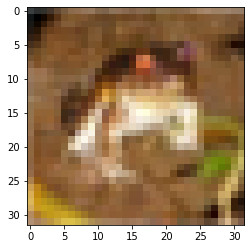

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

### np.ndarray转为torch.Tensor

在深度学习中，原始图像需要转换为深度学习框架自定义的数据格式，在pytorch中，需要转为`torch.Tensor`。
pytorch提供了`torch.Tensor` 与`numpy.ndarray`转换为接口：

方法名|作用
--|--
`torch.from_numpy(xxx)`|`numpy.ndarray`转为torch.Tensor
`tensor1.numpy()`|获取tensor1对象的numpy格式数据

`torch.Tensor` 高维矩阵的表示： N x C x H x W

`numpy.ndarray` 高维矩阵的表示：N x H x W x C

因此在两者转换的时候需要使用`numpy.transpose( )` 方法 。


In [10]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

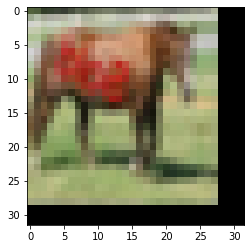

In [11]:
imshow(im[0])

In [12]:
im[0].shape

torch.Size([3, 32, 32])

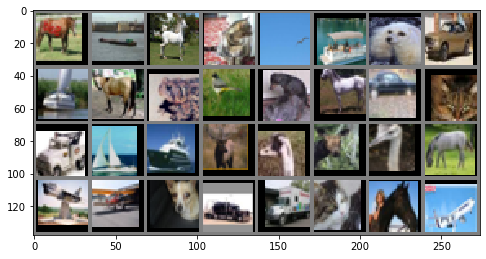

In [13]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

### 4.定义网络（LeNet5）

手写字体识别模型LeNet5诞生于1994年，是最早的卷积神经网络之一。LeNet5通过巧妙的设计，利用卷积、参数共享、池化等操作提取特征，避免了大量的计算成本，最后再使用全连接神经网络进行分类识别，这个网络也是最近大量神经网络架构的起点。

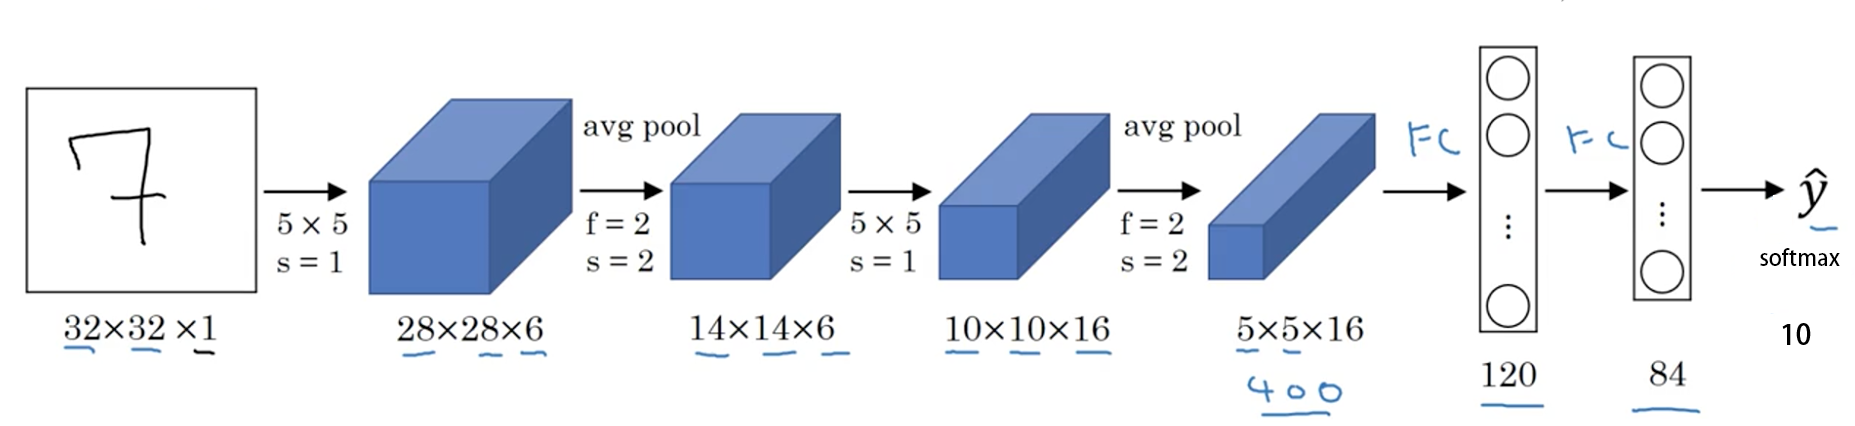


LeNet-5 一些性质：

- 如果输入层不算神经网络的层数，那么 LeNet-5 是一个 7 层的网络。（有些地方也可能把 卷积和池化 当作一个 layer）（LeNet-5 名字中的“5”也可以理解为整个网络中含可训练参数的层数为 5。）
    
- LeNet-5 大约有 60,000 个参数。
    
- 随着网络越来越深，图像的高度和宽度在缩小，与此同时，图像的 channel 数量一直在增加。
    
- 现在常用的 LeNet-5 结构和 Yann LeCun 教授在 1998 年论文中提出的结构在某些地方有区别，比如激活函数的使用，现在一般使用 ReLU 作为激活函数，输出层一般选择 softmax。

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
#定义网络
class LeNet5(nn.Module):# nn.Module是所有神经网络的基类，我们自己定义任何神经网络，都要继承nn.Module
    def __init__(self):
        super(LeNet5,self).__init__()
        self.conv1 = nn.Sequential(
            # 卷积层1，3通道输入，6个卷积核，核大小5*5
            # 经过该层图像大小变为32-5+1，28*28
            nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,stride=1, padding=0),
            #激活函数
            nn.ReLU(),
            # 经2*2最大池化，图像变为14*14
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
        )
        self.conv2 = nn.Sequential(
            # 卷积层2，6输入通道，16个卷积核，核大小5*5
            # 经过该层图像变为14-5+1，10*10
            nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1, padding=0),
            nn.ReLU(),
            # 经2*2最大池化，图像变为5*5
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
        )
        self.fc = nn.Sequential(
            # 接着三个全连接层
            nn.Linear(16*5*5,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10),
        )
        
        # 定义前向传播过程，输入为
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        # nn.Linear()的输入输出都是维度为一的值，所以要把多维度的tensor展平成一维
            
        x = x.view(x.size()[0],-1)
        x = self.fc(x)
        return x
            
net = LeNet5().cuda()

In [16]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [17]:
print(net)

LeNet5(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [18]:
test_x = torch.randn(1,3,32,32).to(device)
test_y = net(test_x)
print(test_y.shape)

torch.Size([1, 10])


In [19]:
net =LeNet5().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

### 5. 定义损失函数和优化器 

pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier
    
损失函数是封装在神经网络工具箱nn中的,包含很多损失函数


In [20]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5 ,patience = 5,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
import time
epoch = 20

### 6. 训练

In [21]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/LeNet5.pth'

文件已存在


In [22]:
from utils import train
from utils import plot_history
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

Epoch [  1/ 20]  Train Loss:1.923351  Train Acc:28.03% Test Loss:1.691635  Test Acc:38.68%  Learning Rate:0.100000	Time 00:24
Epoch [  2/ 20]  Train Loss:1.592739  Train Acc:41.32% Test Loss:1.474858  Test Acc:46.65%  Learning Rate:0.100000	Time 00:23
Epoch [  3/ 20]  Train Loss:1.477126  Train Acc:46.01% Test Loss:1.511801  Test Acc:45.17%  Learning Rate:0.100000	Time 00:23
Epoch [  4/ 20]  Train Loss:1.407370  Train Acc:49.15% Test Loss:1.410033  Test Acc:48.70%  Learning Rate:0.100000	Time 00:23
Epoch [  5/ 20]  Train Loss:1.359725  Train Acc:51.06% Test Loss:1.340946  Test Acc:51.33%  Learning Rate:0.100000	Time 00:22
Epoch [  6/ 20]  Train Loss:1.309393  Train Acc:53.26% Test Loss:1.315299  Test Acc:53.29%  Learning Rate:0.100000	Time 00:20
Epoch [  7/ 20]  Train Loss:1.289646  Train Acc:54.13% Test Loss:1.300248  Test Acc:53.34%  Learning Rate:0.100000	Time 00:22
Epoch [  8/ 20]  Train Loss:1.269938  Train Acc:55.21% Test Loss:1.295666  Test Acc:54.19%  Learning Rate:0.100000	Tim

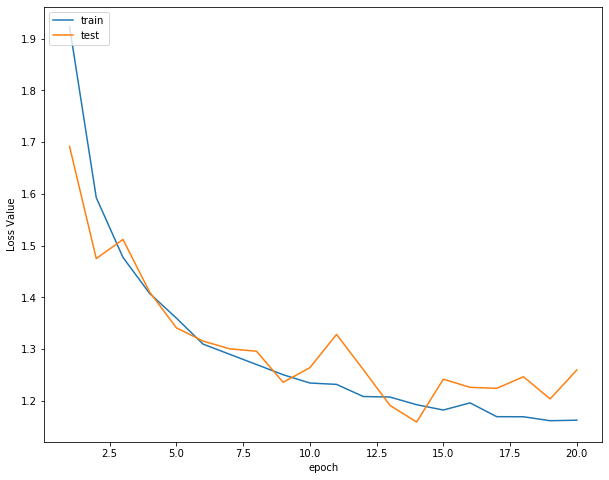

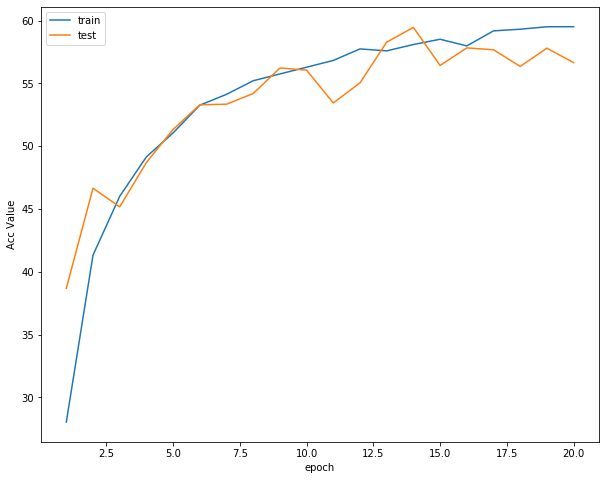

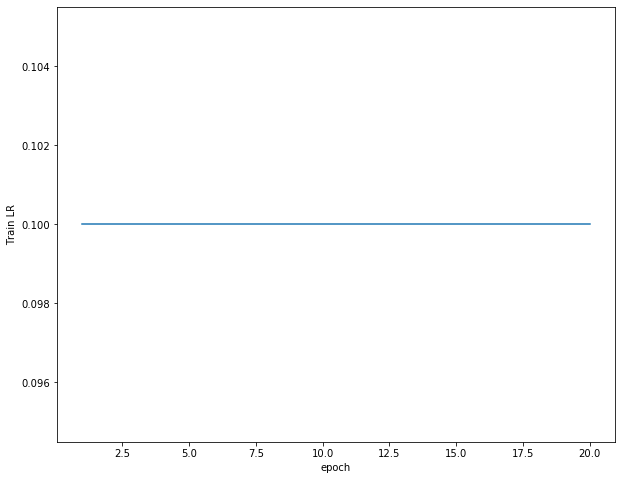

In [23]:
plot_history(epoch ,Acc, Loss, Lr)

### 7.测试

Accuracy Rate = 62.890625%


<Figure size 1800x288 with 0 Axes>

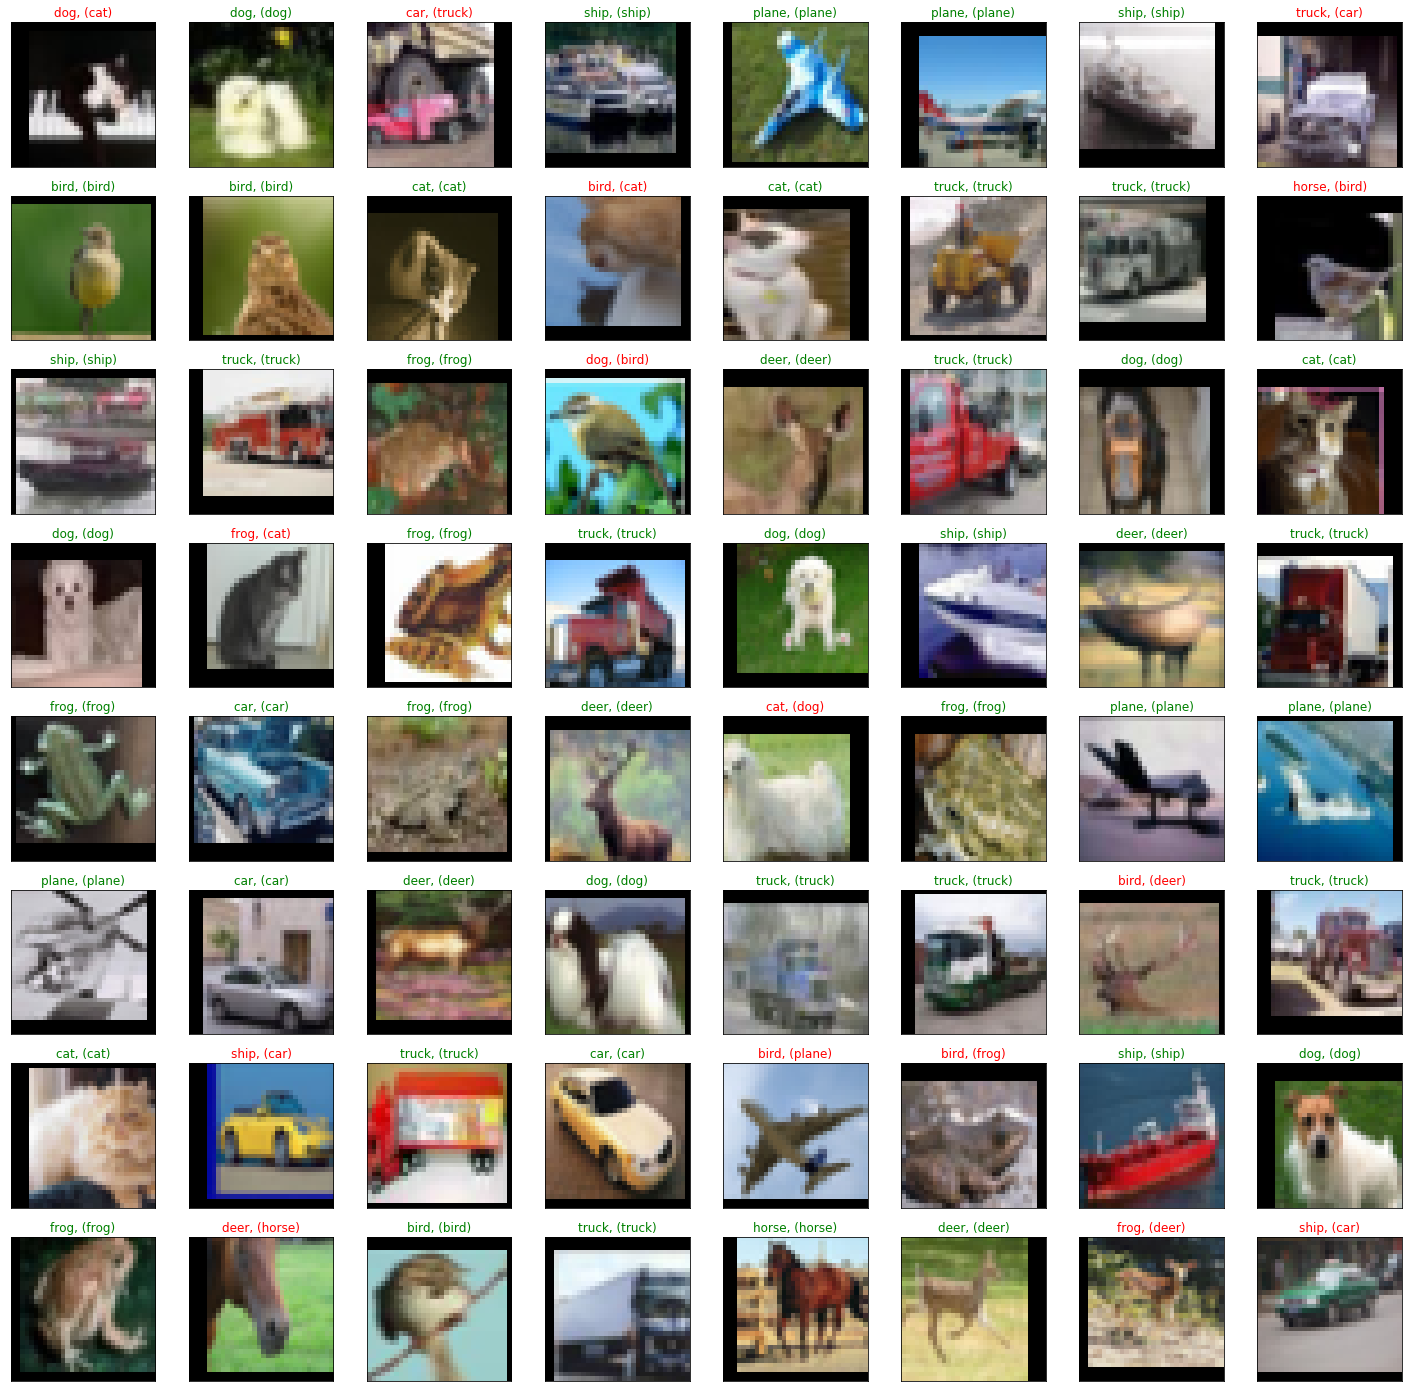

In [29]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

In [30]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
for data in testloader:  # 循环每一个batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval()  # 把模型转为test模式
    if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
    outputs = net(images)  # 输入网络进行测试
    
    # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)          # 更新测试图片的数量
    correct += (predicted == labels).sum() # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
 

Accuracy of the network on the 10000 test images: 56.61 %


程序中的 `torch.max(outputs.data, 1)` ，返回一个tuple (元组)

而这里很明显，这个返回的元组的第一个元素是image data，即是最大的 值，第二个元素是label， 即是最大的值 的 索引！我们只需要label（最大值的索引），所以就会有` _ `,predicted这样的赋值语句，表示忽略第一个返回值，把它赋值给` _`， 就是舍弃它的意思；

In [31]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52.30 %
Accuracy of   car : 65.50 %
Accuracy of  bird : 58.30 %
Accuracy of   cat : 36.30 %
Accuracy of  deer : 45.20 %
Accuracy of   dog : 34.30 %
Accuracy of  frog : 74.80 %
Accuracy of horse : 48.40 %
Accuracy of  ship : 84.90 %
Accuracy of truck : 68.60 %


### 8. 保存模型

In [32]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')
# torch.save(net, './model/ResNet34.pth')

### 9. 预测

In [35]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LeNet5()

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像

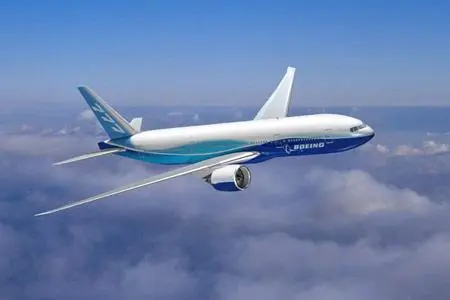

In [36]:
img

In [37]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[1.7789e-01, 2.7222e-04, 1.6041e-04, 7.4237e-05, 1.3309e-04, 7.5238e-06,
         8.7515e-06, 1.1153e-06, 8.2116e-01, 2.8905e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
类别 8
tensor([8.0762], device='cuda:0')
分类 ship


c:\users\86137\appdata\local\programs\python\python37\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


<Response [200]>


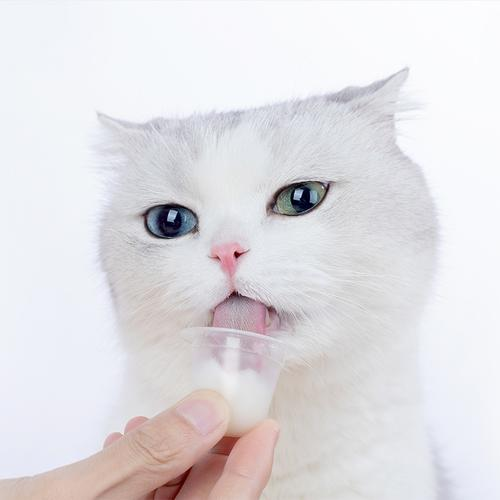

In [38]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [39]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[0.4155, 0.0006, 0.2607, 0.0950, 0.0727, 0.0394, 0.0241, 0.0135, 0.0756,
         0.0029]], device='cuda:0', grad_fn=<SoftmaxBackward>)
类别 0
tensor([2.5997], device='cuda:0')
分类 plane


c:\users\86137\appdata\local\programs\python\python37\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
